In [7]:
import sys
sys.path.append('../src')

import argparse
import logging
import logging.config
import os
import random
from fractions import Fraction
from pathlib import Path
from typing import Any, cast

import hydra
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import wandb
import yaml
from ffcv.loader import Loader
from omegaconf import OmegaConf
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

from attacks import PGD
from dataset import get_dataloader
from schema.config import Config
from utils.constants import (
  get_loss_func,
  get_model,
  get_optimizer,
)

ROOT = Path('../').resolve()
CONFIG_PATH = ROOT / 'configs'

def fraction_resolver(s: str) -> float:
  f = Fraction(s)
  return float(f)

OmegaConf.register_new_resolver('fraction', fraction_resolver)

with hydra.initialize_config_dir(config_dir=str(CONFIG_PATH), version_base='1.1'):
  yaml_config = hydra.compose(config_name='main')

  default_config = OmegaConf.structured(Config)

  config = cast(Config, OmegaConf.merge(default_config, yaml_config))
  # config = cast(Config, hydra.compose(config_name=args.config))

config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
# seed_everything(config.seed)

config.input_path = ROOT / config.input_dir

with open(CONFIG_PATH / 'log_config.yaml') as f:
  log_config = yaml.safe_load(f)

logging.config.dictConfig(log_config)
file_handler = logging.FileHandler(config.output_path / 'out.log')
file_handler.setLevel('INFO')
file_handler.setFormatter(logging.Formatter("%(asctime)s %(name)s:%(lineno)s %(funcName)s [%(levelname)s]: %(message)s"))

for name in ['__main__', 'same_hierarchy', 'lower.sub']:
  logger = logging.getLogger(name)
  logger.addHandler(file_handler)

# torch.set_float32_matmul_precision('highest')
# torch.set_default_dtype(torch.float32)
print(cast(dict[str, Any], OmegaConf.to_object(config)))


Config(debug_mode=False, seed=0, input_dir='input', output_dir='output', save_model=True, wandb=WandbConfig(project='grokking_adversarial'), train=TrainConfig(optimization_steps=500000, batch_size=256, optimizer='adamw', learning_rate=0.001, weight_decay=0.0, loss=<LossType.ce: 'ce'>, label_smoothing=0.0, subset_size=50000, grad_norm=1.0), val=ValConfig(batch_size=2048), local_complexity=LocalComplexityConfig(compute_lc=True, approx_n=1024, n_frame=40, r_frame=0.005, lc_batch_size=256), adversarial=AdversarialConfig(compute_robust=True, atk_epochs=10, dmax=2.7537, dmin=-2.4291, atk_eps=0.06274509803921569, atk_alpha=0.01568627450980392), train_adv_samples=TrainAdvSamplesConfig(enable=False, interrupt_step=3500, train_size=1000), dataset=DatasetConfig(name='cifar-10', format='ffcv', num_classes=10, num_workers=28), mnist=MNISTConfig(initialization_scale=1), model='preact_resnet18', mlp=MLPConfig(hidden_dim=200, hidden_layers=1), resnet=ResNetConfig(bn='identity'), log_steps=[], device='

In [37]:
def evaluate(
  config: Config,
  model: nn.Module,
  criterion: nn.Module,
  dataloader: DataLoader[tuple[torch.Tensor, int]] | Loader,
) -> npt.NDArray[np.float32]:
  model.eval()

  total_loss = torch.tensor(0.0, device=config.device)
  total_correct = torch.tensor(0, device=config.device)
  total_samples = 0

  confidence: list[torch.Tensor] = []
  for images, labels in dataloader:
    images = cast(torch.Tensor, images)
    labels = cast(torch.Tensor, labels)

    images = images.to(config.device, non_blocking=True)
    labels = labels.to(config.device, non_blocking=True)

    with torch.no_grad():
      y_logit = model(images)
      loss = criterion(y_logit, labels)
    total_loss += loss

    y_prob = F.softmax(y_logit, dim=1)
    y_pred = y_prob.argmax(dim=1)
    correct = (y_pred == labels).sum()
    total_correct += correct
    total_samples += labels.shape[0]

    correct_probs = y_prob[torch.arange(labels.shape[0]), labels]
    confidence.append(correct_probs.cpu())

  avg_loss = total_loss / len(dataloader)
  avg_acc = total_correct / total_samples if total_samples > 0 else torch.tensor(0.0)

  # return avg_loss.item(), avg_acc.item()
  return torch.cat(confidence).numpy()

transforms = T.Compose([
  T.ToTensor(),
  T.ConvertImageDtype(torch.float32),
  T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

train_dataloader = get_dataloader(config, transforms=transforms)
val_dataloader = get_dataloader(config, train=False, transforms=transforms)

model = get_model(config.model, config).to(
  device=config.device,
  non_blocking=True,
  memory_format=torch.channels_last
)
model = cast(nn.Module, model)

state_dict = torch.load(ROOT / 'checkpoints/baseline/last.pt')
model.load_state_dict(state_dict)

loss_fn = nn.CrossEntropyLoss()

confidence = evaluate(
  config,
  model,
  loss_fn,
  val_dataloader
)


  # tqdm_ = tqdm(range(config.train.num_epochs), )
  # for epoch in tqdm_:


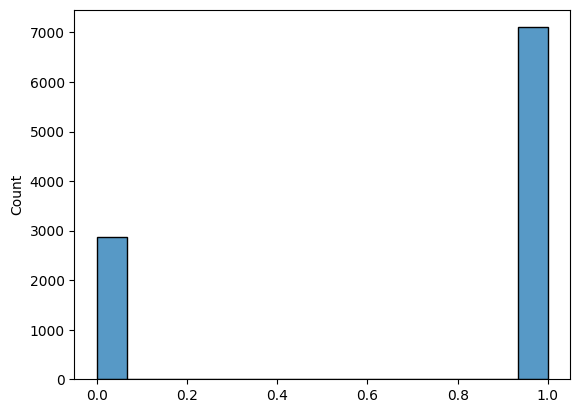

In [14]:
fig, ax = plt.subplots()
sns.histplot(confidence, ax=ax)
plt.show()


In [36]:
np.unique(low_conf)


array([1.40129846e-45, 2.80259693e-45, 8.40779079e-45, 9.80908925e-45,
       1.26116862e-44, 1.40129846e-44, 1.54142831e-44, 1.68155816e-44,
       2.10194770e-44, 2.94272678e-44, 3.08285662e-44, 3.36311631e-44,
       3.64337601e-44, 5.18480432e-44, 5.46506401e-44, 5.74532370e-44,
       6.16571324e-44, 6.44597294e-44, 1.06498683e-43, 1.30320757e-43,
       1.49938936e-43, 1.94780487e-43, 2.08793471e-43, 2.17201262e-43,
       2.55036321e-43, 3.78350585e-43, 4.23192136e-43, 5.32493416e-43,
       5.50710296e-43, 7.30076500e-43, 1.01874398e-42, 1.21632707e-42,
       1.39569327e-42, 1.86232566e-42, 2.05570485e-42, 3.25241374e-42,
       3.78210456e-42, 5.28009261e-42, 5.51691205e-42, 5.76914578e-42,
       6.64916121e-42, 9.20933351e-42, 1.12762487e-41, 1.83724242e-41,
       1.87255514e-41, 2.00077395e-41, 2.78676226e-41, 7.37937784e-41,
       1.25424620e-40, 2.71040550e-40, 3.24847609e-40, 3.62211831e-40,
       3.88051775e-40, 4.00641040e-40, 4.17131520e-40, 4.36357335e-40,
      

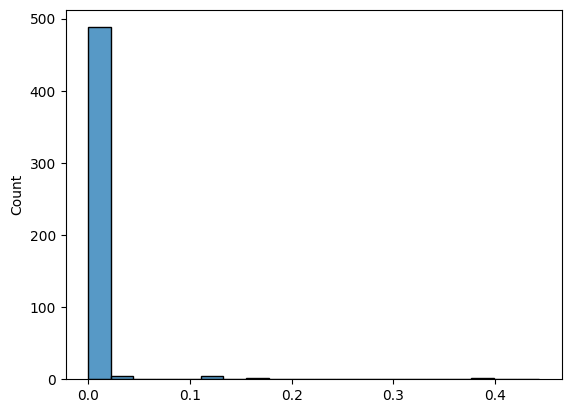

In [35]:
low_conf = confidence[(confidence < 0.5) & (confidence != 0)]
high_conf = confidence[confidence >= 0.5]

fig, ax = plt.subplots()
sns.histplot(low_conf, ax=ax, bins=20)
plt.show()
